<a href="https://colab.research.google.com/github/Ajodo-Godson/Ajodo-Godson/blob/main/autoencoders_pcw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Question 1: Autoencoder Intro (2)

In 150 words or less, describe the "nonlinear dimensionality reduction" property of autoencoders. Does this make them more or less expressive than PCA?

Answer here.

### Question 2: Autoencoding Handwritten Digits (3)

In this question, we revisit the neural network code from the Backpropagation lesson, and rework it to become an autoencoder!

In [1]:
%pip install jax[cpu]
%pip install optax

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import optax

from sklearn import datasets
from matplotlib import pyplot as plt

In [ ]:
digits = datasets.load_digits()
x_data, y_data = digits['data'], digits['target']

x_data = x_data / 16 # from 0 to 16, to 0 to 1 range

Let's visualize one of the data points in this dataset:

<function matplotlib.pyplot.show(close=None, block=None)>

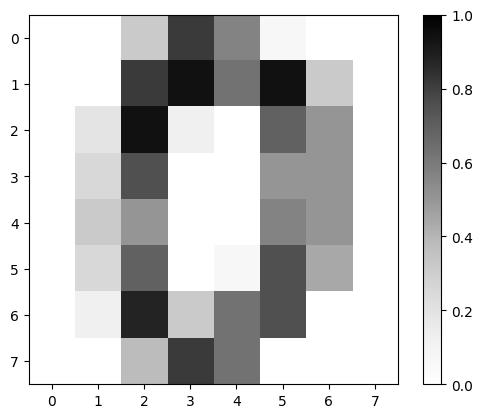

In [ ]:
plt.imshow(x_data[0].reshape(8, 8), cmap="Greys", vmin=0, vmax=1)
plt.colorbar()
plt.show()

Now, we set up the autoencoder: it's just another neural network, where *halfway through the network* we have a "bottleneck layer". The bottleneck is *significantly* smaller than the inputs *and* the rest of the network:

* The input is 64 dimensional
* The hidden layers are 8 dimensional
* The bottleneck is only 2 dimensional. That is, *all* subsequent layers past the bottleneck will only receive whatever information is "compressed" into this 2D bottleneck.

In [ ]:
input_dim = 64
hidden_dim = 8
bottleneck_dim = 2
output_dim = input_dim

params = {
    "layer_1": {
        "W": np.random.normal(size=(input_dim, hidden_dim)) / np.sqrt(input_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_2": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_3": {
        "W": np.random.normal(size=(hidden_dim, bottleneck_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(bottleneck_dim,)),
    },
    "layer_4": {
    "W": np.random.normal(size=(bottleneck_dim, hidden_dim)) / np.sqrt(bottleneck_dim),
    "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_5": {
        "W": np.random.normal(size=(hidden_dim, output_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(output_dim,)),
    },
}

# Pay close attention to this function for the next question.
def predict_fn(params, X):
    X0 = X
    # remember, * is an elementwise multiply, whereas @ is a matrix multiply.
    X1 = jax.nn.relu(X0 @ params["layer_1"]["W"] + params["layer_1"]["b"])
    X2 = jax.nn.relu(X1 @ params["layer_2"]["W"] + params["layer_2"]["b"])
    X3 = X2 @ params["layer_3"]["W"] + params["layer_3"]["b"]
    X4 = jax.nn.relu(X3 @ params["layer_4"]["W"] + params["layer_4"]["b"])
    X5 = jax.nn.sigmoid(X4 @ params["layer_5"]["W"] + params["layer_5"]["b"])
    return {'reconstruct': X5, 'bottleneck': X3}

def loss_fn(params, X):
    reconstruct_X = predict_fn(params, X)['reconstruct']
    loss = -(X * jnp.log(reconstruct_X) + (1 - X) * jnp.log(1 - reconstruct_X))
    return jnp.mean(loss)

**Questions 2a**: Answer the following
* How many layers does this network have?
* Which layer is the "bottleneck layer"?
* How many layers does the encoder (the layers before bottleneck) and the decoder (the layers after the bottleneck) have?
* Why are they called "encoder" and "decoder"?
* Why are we returning `{'reconstruct': X5, 'bottleneck': X3}`? Why are these two values special?

Answer here.

Now, let's train this model!

In [ ]:
step_size = 0.01
total_steps = 3000

# We use an optimizer called Adam here.
# We won't go into detail, but think of it as "fast gradient descent"
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

grad_loss_fn = jax.grad(loss_fn)
grad_loss_fn = jax.jit(grad_loss_fn)

for i in range(total_steps):
    idxs = np.random.randint(low=0, high=x_data.shape[0], size=32)
    x_batch = x_data[idxs]
    # Remember, we compute gradients of the *first* argument, which is params.
    grad = grad_loss_fn(params, x_batch)
    update, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, update)

    # We print the loss every 100 steps
    if i % 100 == 0:
        loss_val = loss_fn(params, x_data)
        print("Step:", i, "Loss:", loss_val)

Step: 0 Loss: 0.69891053
Step: 100 Loss: 0.59895396
Step: 200 Loss: 0.47109348
Step: 300 Loss: 0.4294746
Step: 400 Loss: 0.42091924
Step: 500 Loss: 0.41769964
Step: 600 Loss: 0.4155059
Step: 700 Loss: 0.41335496
Step: 800 Loss: 0.4118622
Step: 900 Loss: 0.41057205
Step: 1000 Loss: 0.40900186
Step: 1100 Loss: 0.40193918
Step: 1200 Loss: 0.39505547
Step: 1300 Loss: 0.39159375
Step: 1400 Loss: 0.3900956
Step: 1500 Loss: 0.38915655
Step: 1600 Loss: 0.3882955
Step: 1700 Loss: 0.38742164
Step: 1800 Loss: 0.38700196
Step: 1900 Loss: 0.3862485
Step: 2000 Loss: 0.38554287
Step: 2100 Loss: 0.38502392
Step: 2200 Loss: 0.38452315
Step: 2300 Loss: 0.3839527
Step: 2400 Loss: 0.38327628
Step: 2500 Loss: 0.38287854
Step: 2600 Loss: 0.38237566
Step: 2700 Loss: 0.3818609
Step: 2800 Loss: 0.3815475
Step: 2900 Loss: 0.38095242


Now, this network has two outputs: `reconstruct`, which is an attempt at reconstructing the original input, and `bottleneck`, which is the output of the bottleneck layer itself. Let's see the reconstruction vs the original:

In [ ]:
predict_vals = predict_fn(params, x_data)

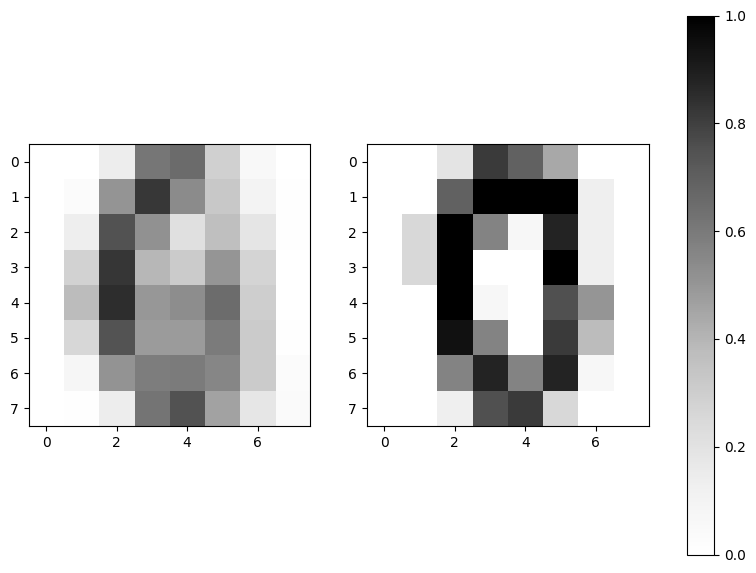

In [ ]:
EXAMPLE_NUMBER = 20

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
img0 = ax[0].imshow(predict_vals['reconstruct'][EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")
img1 = ax[1].imshow(x_data[EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")
fig.colorbar(img0, ax=ax)
plt.show()

**Question 2b**: `x_data` has 1797 examples. Try  different values of `EXAMPLE_NUMBER` within that range to see how well the model reconstructs the original. Qualitatively, how good are these reconstructions, and in what ways are they flawed?

Answer here

We can also extract the bottleneck values. Since the layer is 2 dimensional, we can directly plot it as a scatter plot!

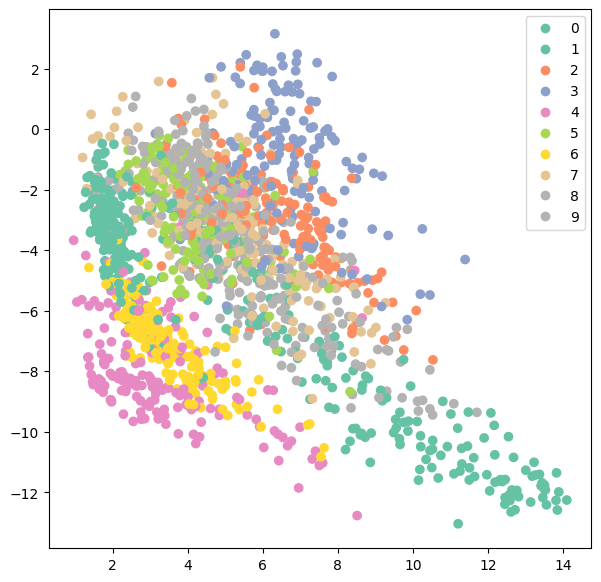

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
scatter = ax.scatter(predict_vals['bottleneck'][:, 0], predict_vals['bottleneck'][:, 1], c=y_data, cmap="Set2")
ax.legend(handles=scatter.legend_elements()[0], labels=list(digits['target_names']))
plt.show()

**Questions 2c:**

1. What behavior do you see in the plot above? Are bottleneck vectors of images of the same digit closer or further apart?
2. What can you say about this plot, given that the model *never* sees the labels during training (it purely reconstructs every digit image as provided, with no additional information about what class it belongs to)?

Answer here

### Question 3: A better autoencoder (4)

In the code cells below:
* Modify the code above, to extend the model's encoder and decoders from 2 layers to 3 layers each. (This means updating both the forward pass, and the weight initialization)
* Rerun training with this modified model, and record the loss you obtain. Is it better than in question 2?

You may copy any of the code from the cells above as needed, and modify them.